# dependencies

libpath in windows

In [ ]:
import sys
lib_path = ['G:\\gitcode\\python-wsi-preprocessing\\deephistopath\\wsi','G:\\gitcode\\python-wsi-preprocessing']
for i in lib_path:
    if i not in lib_path:
        sys.path.append(i)
        importlib.reload(i)

libpath in linux

In [332]:
import sys
import os
lib_path = ['/home/wangyh/uro_biomarker/python-wsi-preprocessing/deephistopath/wsi','/home/wangyh/uro_biomarker/python-wsi-preprocessing']
for i in lib_path:
    sys.path.append(i)

openslide_path = {'desktop':'D:/edge下载/openslide-win64-20220811/bin',
                'laptop':'E:/openslide-win64-20171122/bin'}
if hasattr(os,'add_dll_directory'):
    for i in openslide_path.values():
        if Path(i).exists():
            with os.add_dll_directory(Path(i)):
                import openslide
else:
    import openslide

In [ ]:
import importlib
import glob
import pandas as pd
import numpy as np
import tifffile as tif
from func import basic
from func import visualization
from matplotlib import pyplot as plt
from pathlib import Path
import multiprocessing
from multiprocessing import Pool
from deephistopath.wsi.util import Time
import math
import PIL
importlib.reload(visualization)


In [ ]:
import filter
import slide as sl
import tiles
import util

In [344]:
importlib.reload(filter)
importlib.reload(sl)
importlib.reload(tiles)
importlib.reload(util)

<module 'util' from '/home/wangyh/uro_biomarker/python-wsi-preprocessing/deephistopath/wsi/util.py'>

# functions

In [ ]:
def check_filters(file_list,filter):
    results = []
    for i in file_list:
        results.append(filter(i))
    scale = len(file_list)//5+1
    visualization.ploting(scale,5,figseq = results,cmap = 'gray')
    
def filter_compare(file:np.ndarray,filters,figsize = (20,10)):
    results = [file]
    title = ['original']
    for filter in filters:
        results.append(filter(file))
        title.append(filter.__name__)
    visualization.ploting(1,len(results),figseq=results,title = title,cmap = 'gray',figsize = figsize)

def multiple_filter_compare(files,filters,figsize = (20,10),sm = False):
    results = []
    title = []
    for i,file in enumerate(files):
        results.append(file)
        title.append(f'index{i}')
        for filter in filters:
            results.append(filter(file))
            if sm:
                title.append(f'{filter.__name__},sum={filter(file).sum()}')
            else:
                title.append(f'{filter.__name__}')
    visualization.ploting(len(files),len(filters)+1,figseq=results,title = title,cmap = 'gray',figsize=figsize)

# remove masks demo

In [ ]:
# root_path = {'linux':'/mnt/wangyh/CN_patches',
#             'desktop':'G:/gitcode/CN patches'}

tifseq_5x = glob.glob('/mnt/wangyh/CN_patches/L/e20c2176-2b57-4cc9-a68a-eb6933bf60b1/5X/*')
tifseq_10x = glob.glob('/mnt/wangyh/CN_patches/L/e20c2176-2b57-4cc9-a68a-eb6933bf60b1/10X/*')
tifseq_20x = glob.glob('/mnt/wangyh/CN_patches/L/e20c2176-2b57-4cc9-a68a-eb6933bf60b1/20X/*')
tifseq_40x = glob.glob('/mnt/wangyh/CN_patches/L/e20c2176-2b57-4cc9-a68a-eb6933bf60b1/40X/*')

# read tif in folders
tif_5x = tif.TiffSequence(tifseq_5x).asarray()
tif_10x = tif.TiffSequence(tifseq_10x).asarray()
tif_20x = tif.TiffSequence(tifseq_20x).asarray()
tif_40x = tif.TiffSequence(tifseq_40x).asarray()

In [ ]:
%matplotlib inline

In [ ]:
# visualization.ploting(len(tif_5x)//5+1,5,figseq=tif_5x)

In [ ]:
t5 = tif_5x[0]
filter_compare(t5,filters=[filter.filter_grays,filter.filter_green_channel,filter.filter_blue_pen,filter.filter_red_pen,filter.filter_remove_small_objects])

In [ ]:
# basic.show_info(gray = filter.filter_blue_pen(t5),red = filter.filter_red_pen(t5),small = filter.filter_remove_small_objects(t5),show_OI = True)
red = filter.filter_red_pen(t5)
red.sum()

In [ ]:
# multiple_filter_compare(tif_20x[17:20],filters = [filter.filter_grays,filter.filter_green_channel,filter.filter_blue_pen,filter.filter_red_pen,filter.filter_remove_small_objects])

# methodology explore:select suitable filter using HSV

## functions

In [ ]:
df = pd.read_csv('../config/full.csv')
THUMBNAIL_SIZE = 300
SCALE_FACTOR = 32

def get_num_training_slides():
    '''
    Obtain the total number of WSI training slide images.

    Returns:
    The total number of WSI training slide images.
    '''
    uuid = df['dir_uuid']
    return len(uuid)


def get_training_slide_path(slide_number):
    """
    Convert slide number to a path to the corresponding WSI training slide file.

    Args:
    slide_number: the index of slide.

    Returns:
    Path to the WSI training slide file.
    """
    svs_path = df['svs_paths']
    slide_filepath = svs_path[slide_number]
    return slide_filepath


def save_thumbnail(pil_img, size, path, display_path=False):
    """
    Save a thumbnail of a PIL image, specifying the maximum width or height of the thumbnail.

    Args:
    pil_img: The PIL image to save as a thumbnail.
    size:  The maximum width or height of the thumbnail.
    path: The path to the thumbnail.
    display_path: If True, display thumbnail path in console.
    """
    max_size = tuple(round(size * d / max(pil_img.size)) for d in pil_img.size)
    img = pil_img.resize(max_size, PIL.Image.BILINEAR)
    if display_path:
        print("Saving thumbnail to: " + path)
#     dir = os.path.dirname(path)
#     if dir != '' and not os.path.exists(dir):
#         os.makedirs(dir)
    img.save(path)


def slide_to_scaled_pil_image(slide_number):
    """
    Convert one single WSI training slide to a scaled-down PIL image.

    Args:
    slide_number: The index of slide.

    Returns:
    Tuple consisting of scaled-down PIL image, original width, original height, new width, and new height.
    """
    slide_filepath = get_training_slide_path(slide_number)
    print("Opening Slide #%d: %s" % (slide_number, slide_filepath))
    slide = sl.open_slide(slide_filepath)

    large_w, large_h = slide.dimensions
    new_w = math.floor(large_w / SCALE_FACTOR)
    new_h = math.floor(large_h / SCALE_FACTOR)
    level = slide.get_best_level_for_downsample(SCALE_FACTOR)
    whole_slide_image = slide.read_region((0, 0), level, slide.level_dimensions[level])
    whole_slide_image = whole_slide_image.convert("RGB")
    img = whole_slide_image.resize((new_w, new_h), PIL.Image.BILINEAR)
    return img, large_w, large_h, new_w, new_h


def get_training_image_path(slide_number, large_w=None, large_h=None, small_w=None, small_h=None):
    """
    Convert slide number and optional dimensions to a training image path. If no dimensions are supplied,
    the corresponding file based on the slide number will be looked up in the file system using a wildcard.

    Example:
    5 -> ../data/training_png/TUPAC-TR-005-32x-49920x108288-1560x3384.png

    Args:
    slide_number: The slide number.
    large_w: Large image width.
    large_h: Large image height.
    small_w: Small image width.
    small_h: Small image height.

    Returns:
     Path to the image file.
    """
    uuid = df['dir_uuid']
    img_path = '/mnt/wangyh/svs_img/' + f'{slide_number}' +'.png'
    return img_path

def get_training_thumbnail_path(slide_number, large_w=None, large_h=None, small_w=None, small_h=None):
    """
    Convert slide number and optional dimensions to a training thumbnail path. If no dimensions are
    supplied, the corresponding file based on the slide number will be looked up in the file system using a wildcard.

    Example:
    5 -> ../data/training_thumbnail_jpg/TUPAC-TR-005-32x-49920x108288-1560x3384.jpg

    Args:
    slide_number: The slide number.
    
    Returns:
     Path to the thumbnail file.
    """
    uuid = df['dir_uuid']
    img_path = '/mnt/wangyh/svs_thumb_img/' + f'{slide_number}' +'.jpg'  ### 加一个后缀
    return img_path


def training_slide_to_image(slide_number):
    """
    Convert a WSI training slide to a saved scaled-down image in a format such as jpg or png.

    Args:
    slide_num: index of the slide
    """
    # sldie_to_pil_img
    img, large_w, large_h, new_w, new_h = slide_to_scaled_pil_image(slide_number)

    img_path = get_training_image_path(slide_number, large_w, large_h, new_w, new_h)
    print("Saving image to: " + img_path)
    img.save(img_path)

    thumbnail_path = get_training_thumbnail_path(slide_number, large_w, large_h, new_w, new_h)
    save_thumbnail(img, THUMBNAIL_SIZE, thumbnail_path)


def training_slide_range_to_images(start_ind, end_ind):
    """
    Convert a range of WSI training slides to smaller images (in a format such as jpg or png).

    Args:
    start_ind: Starting index (inclusive).
    end_ind: Ending index (inclusive).

    Returns:
    The starting index and the ending index of the slides that were converted.
    """
    for slide_num in range(start_ind-1, end_ind):
        training_slide_to_image(slide_num)
    return (start_ind, end_ind)


def multiprocess_training_slides_to_images():
    """
    Convert all WSI training slides to smaller images using multiple processes (one process per core).
    Each process will process a range of slide numbers.
    """
    timer = Time()

    # how many processes to use
    num_processes = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(num_processes)

    num_train_images = get_num_training_slides()
    if num_processes > num_train_images:
        num_processes = num_train_images
    images_per_process = num_train_images / num_processes

    print("Number of processes: " + str(num_processes))
    print("Number of training images: " + str(num_train_images))

    # each task specifies a range of slides
    tasks = []
    for num_process in range(1, num_processes + 1):
        start_index = (num_process - 1) * images_per_process + 1
        end_index = min(num_process * images_per_process,get_num_training_slides())
        start_index = int(start_index)
        end_index = int(end_index)
        tasks.append((start_index, end_index))
        if start_index == end_index:
            print("Task #" + str(num_process) + ": Process slide " + str(start_index))
        else:
            print("Task #" + str(num_process) + ": Process slides " + str(start_index) + " to " + str(end_index))

      # start tasks
    results = []
    for t in tasks:
    #TODO:training_slide_range_to_image
        results.append(pool.apply_async(training_slide_range_to_images, t))

    for result in results:
        (start_ind, end_ind) = result.get()
        if start_ind == end_ind:
            print("Done converting slide %d" % start_ind)
        else:
            print("Done converting slides %d through %d" % (start_ind, end_ind))

    timer.elapsed_display()
    
def singleprocess_training_slides_to_images():
    """
    Convert all WSI training slides to smaller images using a single process.
    """
    t = Time()

    num_train_images = get_num_training_slides()
    training_slide_range_to_images()

    t.elapsed_display()

## visualization of thumbnails with marks

In [ ]:
thumbnails = glob.glob('/mnt/wangyh/svs_thumb_img/*')
imgs = glob.glob('/mnt/wangyh/svs_img/*')

In [ ]:
# files in folder are unarranged,meaning the index & number of the file is unmatched.
# read the number in file name, which is corresponding with index of svs in df(full.csv)
# match the number in the file name & index in thumbnails visualization plot, facilitating the identification of the true path of tuples in pen_color_cohort. which is
# corresponding to the index, and the number in file name as well
title=[] 
for i in thumbnails:
    title.append(eval(Path(i).stem)) 

In [ ]:
thumbnails_pic = []
img_pic = []
for i in thumbnails:
    img = plt.imread(i)
    thumbnails_pic.append(img)
# show thumbnails of all slides
visualization.ploting(len(thumbnails_pic)//5+1,5,figseq = np.asarray(thumbnails_pic),figsize = (20,200))

functions

In [ ]:
#get the index of uuid
#if vis, show thumbnails of the slides with the assigned pen mark color
def vis_thumb_marks(pen_color_cohort:list,figsize = (20,20),vis = False) -> list:
    #pen_color_cohort is a list of tuple, tuples are indices of positions of thumbnails,eg:orange_pens =[(8,0),(39,3),(56,2),(62,1)]
    #tuples in cohort are under condition that when parameter 'rows' in function 'visualization.ploting' equals 5
    #full list of thumbnails is read from folder generated by running function 'multiprocess_training_slides_to_images'
    figseq = []
    titles = []
    for i,j in pen_color_cohort:
        index = i*5+j
        figseq.append(thumbnails_pic[index])
        titles.append(title[index])
    if vis:
        visualization.ploting(len(pen_color_cohort)//5+1,5,figseq = figseq,title = titles,figsize = figsize)
    else:
        pass
    return titles

def get_CN_path(index:int,scale:int) ->str:
    uuid = df['dir_uuid'][index]
    folder_path_5x = glob.glob(f'/mnt/wangyh/CN_patches/*/{uuid}/5X/*')
    folder_path_10x = glob.glob(f'/mnt/wangyh/CN_patches/*/{uuid}/10X/*')
    folder_path_20x = glob.glob(f'/mnt/wangyh/CN_patches/*/{uuid}/20X/*')
    folder_path_40x = glob.glob(f'/mnt/wangyh/CN_patches/*/{uuid}/40X/*')
    if scale == 5:
        return folder_path_5x
    elif scale == 10:
        return folder_path_10x
    elif scale == 20:
        return folder_path_20x
    elif scale == 40:
        return folder_path_40x
    else:
        print('\nivalid scale\n')

# to check if the indices get proper slide
def get_original_img(index:int,show = False):
    uuid = df['dir_uuid'][index]
    thumb_path = glob.glob(f'/mnt/wangyh/TCGA_svs/{uuid}/*.svs')[0]
    with openslide.OpenSlide(thumb_path) as slide:
        thumb = slide.get_thumbnail((100,100))
    img_path = glob.glob(f'/mnt/wangyh/svs_thumb_img/{index}.*')[0]
    img = plt.imread(img_path)
    if show:
        visualization.ploting(1,2,figseq = [thumb,img],title = ['thumb','converted thumb'],figsize = (20,10))
    else:
        return thumb,img
    
        
def pic_vis(figseq,figsize = (20,20)) -> None:
    #wraps visualization.ploting, for more convinient visualization of figseq
    visualization.ploting(len(figseq)//5+1,5,figseq = figseq,figsize = figsize)

In [ ]:
# multiprocess_training_slides_to_images()

In [ ]:
blue_pens = [(1,2),(21,1),(22,2),(24,3),(25,4),(33,0),(37,3),(46,3),(46,4),(49,1),(57,3),(67,3)]
green_pens = [(1,1),(5,0),(8,0),(17,1),(18,4),(39,3),(49,2),(56,2),(57,3),(62,1)]
red_pens = [(8,0),(10,1),(13,1),(39,3),(41,1),(46,3),(56,2),(57,1),(62,1),(63,0)]
orange_pens =[(8,0),(39,3),(56,2),(62,1)]
black_pens = [(14,0),(17,1),(41,1),(46,3),(49,4),(52,1),(55,3),(68,0)]

In [ ]:
blue_pen_indeces = vis_thumb_marks(blue_pens)
green_pen_indeces = vis_thumb_marks(green_pens)
red_pen_indeces = vis_thumb_marks(red_pens)
orange_pen_indeces = vis_thumb_marks(orange_pens)
black_pen_indeces = vis_thumb_marks(black_pens)

filter blue pen marks

In [ ]:
get_original_img(black_pen_indeces[0],show=True)

In [ ]:
blue_5 = get_CN_path(black_pen_indeces[2],scale = 5)
figseq = visualization.path_to_img_array(blue_5)
# visualization.ploting(len(figseq)//5+1,5,figseq = figseq,figsize = (20,100))
# multiple_filter_compare(figseq,filters = [filter.filter_grays,filter.filter_green_channel,filter.filter_blue_pen,filter.filter_red_pen,filter.filter_remove_small_objects],figsize = (20,100))

In [ ]:
# visualization of tiles
pic_vis(figseq = figseq,figsize = (20,20))

In [ ]:
filter_compare(figseq[5*5+4],filters = [filter.filter_grays,filter.filter_green_channel,filter.filter_blue_pen,filter.filter_red_pen,filter.filter_remove_small_objects])

# fill_small_holes

## examine whether rag helps

fail

In [ ]:
def test_rag(indices,index,scale,row,col,rag_threshold):
    example = get_CN_path(indices[index],scale)
    fig = visualization.path_to_img_array(example)[row*5+col]
    rag_fig = filter.filter_rag_threshold(fig,threshold=rag_threshold)
    gray = filter.filter_grays(fig)
    gray_rag = filter.filter_grays(rag_fig)
    green = filter.filter_green_channel(fig)
    green_rag = filter.filter_green_channel(rag_fig)
    visualization.ploting(1,6,figseq = [fig,rag_fig,gray,gray_rag,green,green_rag],title = ['fig','rag_fig',f'gray,{gray.sum()}',f'gray_rag{gray_rag.sum()}',f'green{green.sum()}',f'green_rag{green_rag.sum()}'])

In [ ]:
test_rag(blue_pen_indeces,2,5,3,4,5)

## examine whether filter small holes helps

In [ ]:
def test_fill_small_holes(indices,index,scale,row,col,fill=100):
    example = get_CN_path(indices[index],scale)
    fig = visualization.path_to_img_array(example)[row*5+col]
    gray = filter.filter_grays(fig,output_type='bool')
    gray_fill = filter.filter_remove_small_holes(gray,min_size = fill,output_type='bool')    
    green = filter.filter_green_channel(fig)
    green_fill = filter.filter_remove_small_holes(green,min_size = fill,output_type='bool')
    visualization.ploting(1,5,figseq = [fig,gray,gray_fill,green,green_fill],title = ['fig',f'gray,{gray.sum()}',f'gray_fill,{gray_fill.sum()}',f'green,{green.sum()}',f'green_fill,{green_fill.sum()}'])
    return fig,gray,gray_fill,green,green_fill

In [ ]:
group = test_fill_small_holes(blue_pen_indeces,3,5,0,1,10000)

In [ ]:
def test_remove_small_holes(indices,index,scale,row,col,fill=100):
    example = get_CN_path(indices[index],scale)
    fig = visualization.path_to_img_array(example)[row*5+col]
    gray = filter.filter_grays(fig,output_type='bool')
    gray_rem = filter.filter_remove_small_objects(gray,min_size = fill,output_type='bool')    
    green = filter.filter_green_channel(fig)
    green_rem = filter.filter_remove_small_objects(green,min_size = fill,output_type='bool')
    visualization.ploting(1,5,figseq = [fig,gray,gray_rem,green,green_rem],title = ['fig',f'gray,{gray.sum()}',f'gray_rem,{gray_rem.sum()}',f'green,{green.sum()}',f'green_rem,{green_rem.sum()}'])
#     return fig,gray,gray_rem,green,green_rem

In [ ]:
test_remove_small_holes(blue_pen_indeces,3,5,0,1,150000)

In [ ]:
def test_binary_erosion(indices,index,scale,row,col,disk_size=5):
    example = get_CN_path(indices[index],scale)
    fig = visualization.path_to_img_array(example)[row*5+col]
    gray = filter.filter_grays(fig,output_type='bool')
    gray_be = filter.filter_binary_erosion(gray,disk_size = disk_size,output_type='bool')    
    green = filter.filter_green_channel(fig)
    green_be = filter.filter_binary_erosion(green,disk_size = disk_size,output_type='bool')
    visualization.ploting(1,5,figseq = [fig,gray,gray_be,green,green_be],title = ['fig',f'gray,{gray.sum()}',f'gray_be,{gray_be.sum()}',f'green,{green.sum()}',f'green_be,{green_be.sum()}'])

In [ ]:
test_binary_erosion(blue_pen_indeces,3,5,0,1,5)

In [ ]:
def test_binary_erosion_remove_holes(indices,index,scale,row,col,fill = 100,disk_size=5):
    example = get_CN_path(indices[index],scale)
    fig = visualization.path_to_img_array(example)[row*5+col]
    gray = filter.filter_grays(fig,output_type='bool')
    gray_be = filter.filter_binary_erosion(gray,disk_size = disk_size,output_type='bool')
    gray_berh = filter.filter_remove_small_objects(gray_be,min_size = fill,output_type='bool')
    green = filter.filter_green_channel(fig)
    green_be = filter.filter_binary_erosion(green,disk_size = disk_size,output_type='bool')
    green_berh = filter.filter_remove_small_objects(green_be,min_size = fill,output_type='bool')
    visualization.ploting(1,7,figseq = [fig,gray,gray_be,gray_berh,green,green_be,green_berh],title = ['fig',f'gray,{gray.sum()}',f'gray_be,{gray_be.sum()}',f'gray_berh,{gray_berh.sum()}',f'green,{green.sum()}',f'green_be,{green_be.sum()}',f'green_berh,{green_berh.sum()}'])

In [ ]:
test_binary_erosion_remove_holes(blue_pen_indeces,3,5,0,1,10000,5)

In [ ]:
def test_binary_dilation(indices,index,scale,row,col,disk_size=10):
    example = get_CN_path(indices[index],scale)
    fig = visualization.path_to_img_array(example)[row*5+col]
    gray = filter.filter_grays(fig,output_type='bool')
    gray_bd = filter.filter_binary_dilation(gray,disk_size = disk_size,output_type='bool')    
    green = filter.filter_green_channel(fig)
    green_bd = filter.filter_binary_dilation(green,disk_size = disk_size,output_type='bool')
    visualization.ploting(1,5,figseq = [fig,gray,gray_bd,green,green_bd],title = ['fig',f'gray,{gray.sum()}',f'gray_rem,{gray_bd.sum()}',f'green,{green.sum()}',f'green_rem,{green_bd.sum()}'])

In [ ]:
test_binary_dilation(blue_pen_indeces,3,5,0,1,10)

In [ ]:
test_binary_dilation(blue_pen_indeces,2,5,3,4,10)

In [ ]:
test_binary_erosion_remove_holes(blue_pen_indeces,2,5,3,4,10000,5)

In [345]:
def marker_killers(indices,index,scale,row,col,disk_size_dil=10,fill = 100,disk_size_ero = 5,FIG = False,SUM = False):
    example = get_CN_path(indices[index],scale)
    fig = visualization.path_to_img_array(example)[row*5+col]
    green = filter.filter_green_channel(fig)
    green_bd = filter.filter_binary_dilation(green,disk_size = disk_size_dil,output_type='bool')
    green_be = filter.filter_binary_erosion(green,disk_size = disk_size_ero,output_type='bool')
    green_berh = filter.filter_remove_small_objects(green_be,min_size = fill,avoid_overmask=False,output_type='bool')
    visualization.ploting(1,4,figseq = [fig,green,green_bd,green_berh],title = ['fig',f'green,{green.sum()}',f'green_bd,{green_bd.sum()}',f'green_berh,{green_berh.sum()}'])
    if FIG:
        return fig,green,green_bd,green_berh
    if SUM:
        return [green.sum(),green_bd.sum(),green_berh.sum()]

Filter Green Channel | Time: 0:00:00.000658  Type: bool    Shape: (512, 512)
Binary Dilation      | Time: 0:00:00.004137  Type: bool    Shape: (512, 512)
Binary Erosion       | Time: 0:00:00.027456  Type: bool    Shape: (512, 512)
Remove Small Objs    | Time: 0:00:00.003705  Type: bool    Shape: (512, 512)


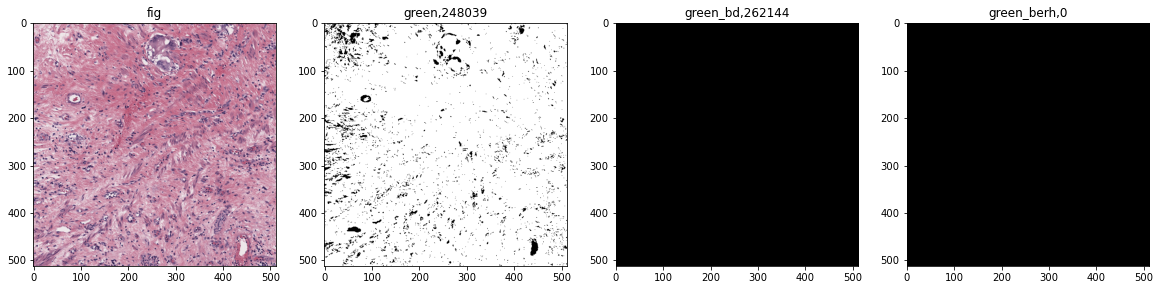

In [346]:
marker_killers(blue_pen_indeces,2,5,3,4,fill=8000,disk_size_ero=10)

In [ ]:
marker_killers(blue_pen_indeces,2,5,3,4,fill=8000,disk_size_ero=10)

In [ ]:
marker_killers(blue_pen_indeces,2,5,0,4,disk_size_dil=10,fill=8000,disk_size_ero=10)

In [ ]:
def check_remover(indices,index,scale,start,end,disk_size_dil=10,fill = 8000,disk_size_ero = 20,f=False,s=False,ploting = False):
#start: start number,index of tile
#end: end-start = plotted tile number,index of end tile +1
    tile_paths = get_CN_path(indices[index],scale)
    fig = visualization.path_to_img_array(tile_paths)
    end = min(len(fig),end)
    fig = fig[start:end]
    removed_markers_pics = []
    removed_markers_sum = []
    title = []
    for i in range(len(fig)//5+1):
        for j in range(5):
            ind = i*5+j
            try:
                tile = fig[ind]
                green = filter.filter_green_channel(tile)
                green_bd = filter.filter_binary_dilation(green,disk_size = disk_size_dil,output_type='bool')
                green_be = filter.filter_binary_erosion(green,disk_size = disk_size_ero,output_type='bool')
                green_berh = filter.filter_remove_small_objects(green_be,min_size = fill,avoid_overmask=False,output_type='bool')
                figseq = [tile,green,green_bd,green_berh]
                Sum = ['',green.sum(),green_bd.sum(),green_berh.sum()]
                titles = [f'original{start+ind}',f'green {green.sum()}',f'green_bd {green_bd.sum()}',f'green_berh {green_berh.sum()}']
                for F in figseq:
                    removed_markers_pics.append(F)
                for T in titles:
                    title.append(T)
                removed_markers_sum.append(Sum)
            except Exception as e:
                print(e,f'{i},{j} has an error')
    if f:
        return removed_markers_pics,title
    if s:
        return removed_markers_sum
    if ploting:
        visualization.ploting(len(fig),4,figseq = removed_markers_pics,title= title,figsize=(20,30))

In [ ]:
check_remover(blue_pen_indeces,3,5,start=45,end=60,disk_size_ero = 25,ploting=True)

In [ ]:
unCN1_path = glob.glob('/mnt/wangyh/TCGA_patches/H/04a64d2e-43dc-4421-9c96-37e8be1d3d92/5X/*')
figseq = visualization.path_to_img_array(unCN1_path)
pic_vis(figseq=figseq[:30])

# confirm: distribution of pic_sums of marked tiles & unmarked tiles

In [ ]:
sum_list = check_remover(blue_pen_indeces,2,10,start=0,end=10000,s=True)

In [ ]:
df_sum = pd.DataFrame(sum_list)
df_sum.columns = ['','green_sum','green_bd','green_berh']

In [ ]:
df_sum[['green_sum','green_bd','green_berh']].plot.density()

In [ ]:
df_sum[['green_sum','green_bd','green_berh']].plot.hist()

# batch processing

## 验证参数

In [314]:
def remove_mark_tile(pen_marks,scale:['5X','10X','20X','40X'],tissue_type:['T','nonT']):
    CN_patches = []
    excluded = []  #存放过滤掉的tile path
    included = []  #存放经过过滤保留下来的tile path
    count = 0
    for index in pen_marks:
        uuid = df['dir_uuid'][index]
        CN_patches_path = glob.glob(f'/mnt/wangyh/CN_patches/*/{uuid}/{scale}/{tissue_type}*')
        count += len(CN_patches_path)
        CN_patches.append(CN_patches_path)
    for obj in CN_patches:
        tifs = visualization.path_to_img_array(obj)
        for i,tif in enumerate(tifs):
            green = filter.filter_green_channel(tif)
            green_bd = filter.filter_binary_dilation(green,disk_size = 10,output_type='bool')
            green_be = filter.filter_binary_erosion(green,disk_size = 20,output_type='bool')
            green_berh = filter.filter_remove_small_objects(green_be,min_size = 8000,avoid_overmask=False,output_type='bool')
            if green_berh.sum() >= 10000:
                excluded.append(obj[i])
            else:
                included.append(obj[i])
    ratio = len(excluded) / count
    return excluded,included,ratio

def check_remover_by_path(paths,start,end,disk_size_dil=10,fill = 8000,disk_size_ero =20):
    fig = visualization.path_to_img_array(paths)
    end = min(len(fig),end)
    fig = fig[start:end]
    title = []
    removed_markers_pics = []
    for i in range(len(fig)//5+1):
        for j in range(5):
            ind = i*5+j
            try:
                tile = fig[ind]
                green = filter.filter_green_channel(tile)
                green_bd = filter.filter_binary_dilation(green,disk_size = disk_size_dil,output_type='bool')
                green_be = filter.filter_binary_erosion(green,disk_size = disk_size_ero,output_type='bool')
                green_berh = filter.filter_remove_small_objects(green_be,min_size = fill,avoid_overmask=False,output_type='bool')
                figseq = [tile,green,green_bd,green_berh]
                Sum = ['',green.sum(),green_bd.sum(),green_berh.sum()]
                titles = [f'original{start+ind}',f'green {green.sum()}',f'green_bd {green_bd.sum()}',f'green_berh {green_berh.sum()}']
                for F in figseq:
                    removed_markers_pics.append(F)
                for T in titles:
                    title.append(T)
            except Exception as e:
                print(e,f'{i},{j} has an error')
    visualization.ploting(len(fig),4,figseq = removed_markers_pics,title= title,figsize=(20,30))

In [320]:
rem_blue_pens = remove_mark_tile(blue_pen_indeces,'5X','T')

In [321]:
excluded = rem_blue_pens[0]
included = rem_blue_pens[1]
ratio = rem_blue_pens[2]

In [ ]:
tovis = visualization.path_to_img_array(rem_blue_pens[1])
pic_vis(tovis,figsize=(20,120))

In [322]:
ratio

0.043583535108958835

## 批处理

In [ ]:
from itertools import product
results = []
for pm,sc,tt in product([blue_pen_indeces,green_pen_indeces,red_pen_indeces,orange_pen_indeces,black_pen_indeces],['5X','10X','20X','40X'],['T','nonT']):
    results.append(remove_mark_tile(pm,sc,tt))

In [356]:
np.save('result_rm.npy',np.asarray(results))

/tmp/ipykernel_1449977/2748510004.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('result_rm.npy',np.asarray(results))


In [ ]:
for i in results:
    excluded_paths = i[0]
    for ex in excluded_paths:
        try:
            os.remove(ex)
        except Exception as e:
            print(f'{ex},{e}')
        

## 验证删除效果

In [375]:
results[1][0][1]

'/mnt/wangyh/CN_patches/H/886d71e2-e5c3-42d5-8a75-646814b3624e/5X/nonT_17_4.tiff'

In [ ]:
tif.imread('/mnt/wangyh/CN_patches/H/886d71e2-e5c3-42d5-8a75-646814b3624e/5X/nonT_17_4.tiff')